In [1]:
!pip install transformers accelerate timm


In [2]:
from transformers import AutoProcessor, GroundingDinoForObjectDetection
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import torch


In [3]:
uploaded = files.upload()
fname = next(iter(uploaded))
img = Image.open(fname).convert("RGB")


Saving fruit-basket.webp to fruit-basket (2).webp


In [4]:
processor = AutoProcessor.from_pretrained("IDEA-Research/grounding-dino-tiny")
model = GroundingDinoForObjectDetection.from_pretrained("IDEA-Research/grounding-dino-tiny")


Enter object: red apple
{'scores': tensor([0.3559, 0.1876, 0.1520], grad_fn=<IndexBackward0>), 'labels': tensor([1, 1, 1]), 'boxes': tensor([[  1.7427,   6.3860, 305.3994, 356.0757],
        [  1.4689,   6.8439, 305.2144, 356.3318],
        [ 19.2243, 145.7858, 111.9402, 231.0402]], grad_fn=<IndexBackward0>)}


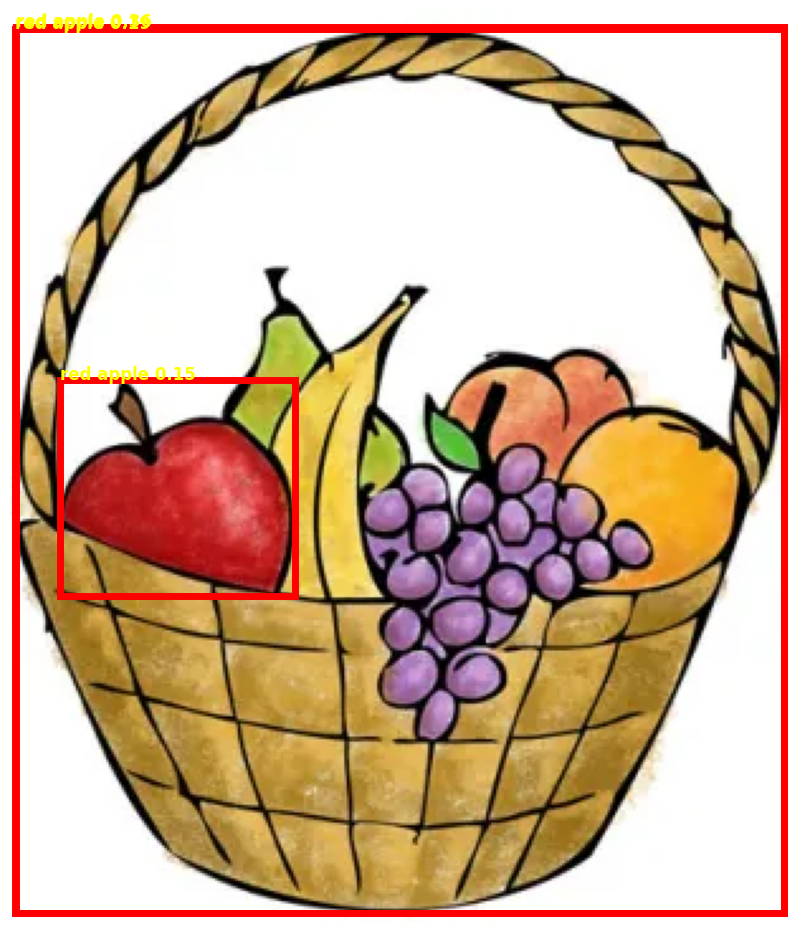

In [5]:
# Ask user what object to detect
text = input("Enter object: ")

# Preprocess + inference
inputs = processor(images=img, text=text, return_tensors="pt")
outputs = model(**inputs)

# Post-process detections
target_sizes = torch.tensor([img.size[::-1]])
results = processor.image_processor.post_process_object_detection(
    outputs, threshold=0.15, target_sizes=target_sizes
)[0]
print(results)
# Plot image with bounding boxes
plt.figure(figsize=(12, 12))
plt.imshow(img)
ax = plt.gca()

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    x0, y0, x1, y1 = box.tolist()
    rect = plt.Rectangle(
        (x0, y0), x1 - x0, y1 - y0,
        fill=False, edgecolor="red", linewidth=5  # <-- made thicker
    )
    ax.add_patch(rect)
    ax.text(x0, y0, f"{text} {score:.2f}", color="yellow", fontsize=12, weight="bold")

plt.axis("off")
plt.show()


In [6]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools

import torch
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamPredictor
import matplotlib.pyplot as plt

# Download smaller, faster SAM ViT-B checkpoint
!wget -O sam_vit_b_01ec64.pth https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

# Load SAM model (ViT-B = faster and lighter)


  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-f3zbmp5q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-f3zbmp5q
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
--2025-10-04 07:28:45--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.37.84, 13.35.37.111, 13.35.37.90, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.37.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M  15.7MB/s    in 24s     

2025-10-04 07:29:09 (15.2 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



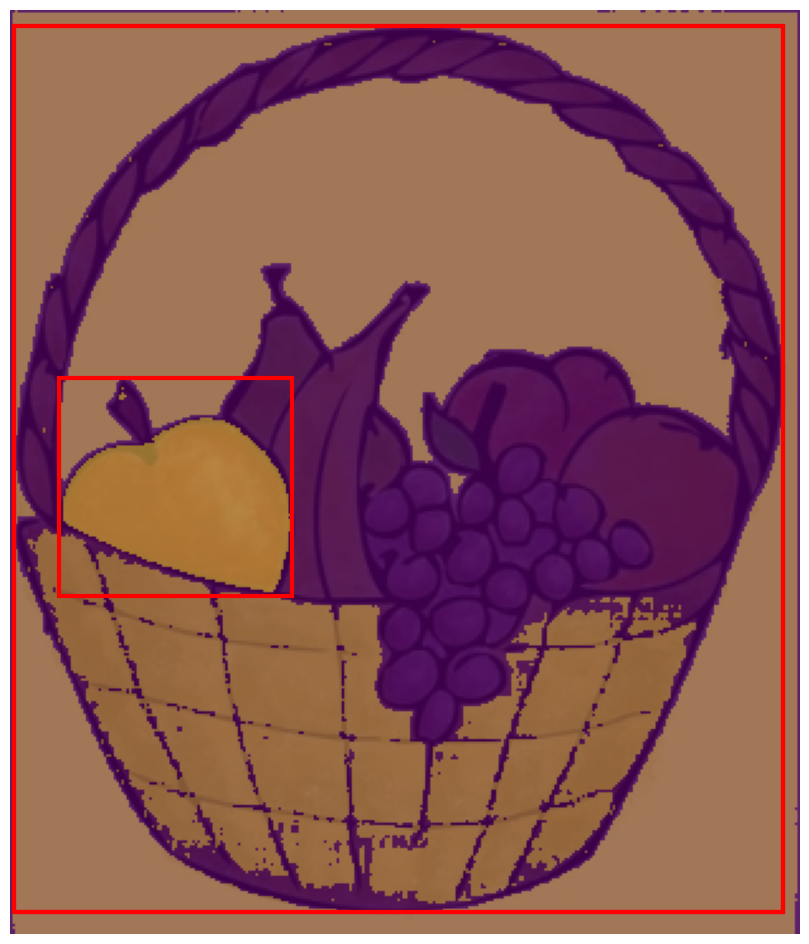

In [8]:
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

# Convert PIL image to numpy array for SAM
image_np = np.array(img)
predictor.set_image(image_np)

# Convert DINO boxes to SAM format (xyxy → np array)
boxes = results["boxes"].detach().cpu().numpy().astype(np.int32)

# Predict masks
masks = []
for box in boxes:
    mask, _, _ = predictor.predict(
        point_coords=None,
        point_labels=None,
        box=box[None, :],  # add batch dimension
        multimask_output=False
    )
    masks.append(mask[0])

# Show results
plt.figure(figsize=(12, 12))
plt.imshow(image_np)

for mask, box in zip(masks, boxes):
    # Overlay mask
    plt.imshow(mask, alpha=0.5)
    # Draw bounding box
    x0, y0, x1, y1 = box
    rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0,
                         fill=False, edgecolor="red", linewidth=3)
    plt.gca().add_patch(rect)

plt.axis("off")
plt.show()
